#run with pathogen_notebook conda env/jupyterlab kernel

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip


In [2]:
os.chdir("/master/nplatt/pathogen_probes/results/seq_analyses/coverage")

In [ ]:
conda activate calc_probe_coverage

cd /master/nplatt/pathogen_probes/results/seq_analyses/coverage

#get reads
cp ../../seq_analyses/01_clean-fastq/*/split-adapter-quality-trimmed/c*.gz .

#get genomes
zcat ../../../data/genomes/trematoda/Schistosoma_mansoni_GCA_000237925.fas.gz            | cut -f1 -d" " >sm.fas
zcat ../../../data/genomes/apicomplexa/Plasmodium_falciparum_GCA_000002765.fas.gz        | cut -f1 -d" " >pf.fas
zcat ../../../data/genomes/apicomplexa/Plasmodium_vivax_GCF_000002415.fas.gz             | cut -f1 -d" " >pv.fas
zcat ../../../data/genomes/mycobacterium/Mycobacterium_tuberculosis_GCF_000195955.fas.gz | cut -f1 -d" " >mt.fas

samtools faidx sm.fas
samtools faidx pf.fas
samtools faidx pv.fas
samtools faidx mt.fas

#get probes
cp ../../../final_probes_v1.1.fas .
cat final_probes_v1.1.fas | paste - - | grep -i -e mycobacterium | sed 's/\t/\n/' >mycobacterium_probes.fas
cat final_probes_v1.1.fas | paste - - | grep -i -e trematod | sed 's/\t/\n/' >trematoda_probes.fas
cat final_probes_v1.1.fas | paste - - | grep -i -e apicomplexa | sed 's/\t/\n/' >plasmodium_probes.fas

#get probe locations###################################################################################

#for mt
conda activate bbmap
bbmap.sh \
    ref=mt.fas \
    in=mycobacterium_probes.fas \
    maxindel=10 \
    threads=48 \
    ambiguous=all \
    out=mycobacterium_probes.sam

conda activate samtools

samtools view -F4 -Sb mycobacterium_probes.sam | samtools sort - >mycobacterium_probes.bam
samtools index mycobacterium_probes.bam

conda activate bedtools
bedtools bamtobed -i mycobacterium_probes.bam >mycobacterium_probes.bed
bedtools merge -d 100 -i mycobacterium_probes.bed >mycobacterium_probes.merged.bed
#49 loci


#get probe locations for sm
bbmap.sh \
    ref=sm.fas \
    in=trematoda_probes.fas \
    maxindel=10 \
    threads=48 \
    ambiguous=all \
    out=trematoda_probes.sam

samtools view -F4 -Sb trematoda_probes.sam | samtools sort - >trematoda_probes.bam
samtools index trematoda_probes.bam

bedtools bamtobed -i trematoda_probes.bam >trematoda_probes.bed
bedtools merge -d 100 -i trematoda_probes.bed >trematoda_probes.merged.bed
#49 loci



#get probe locations for pf
bbmap.sh \
    ref=pf.fas \
    in=plasmodium_probes.fas \
    maxindel=10 \
    threads=48 \
    ambiguous=all \
    out=plasmodium_probes.sam

samtools view -F4 -Sb plasmodium_probes.sam | samtools sort - >plasmodium_probes.bam
samtools index plasmodium_probes.bam

bedtools bamtobed -i plasmodium_probes.bam >plasmodium_probes.bed
bedtools merge -d 100 -i plasmodium_probes.bed >plasmodium_probes.merged.bed
#49 loci

###################################################################################


#map reads to reference genomes ###################################################################################

for REF in mt pf sm; do
    for SAMPLE in c1e_3p_control_enrich c1p_control_enrich c1p_control_no_enrich; do
        echo ${REF} vs ${SAMPLE}
        bbmap.sh \
            ref=${REF}.fas \
            in=${SAMPLE}-READ1.fastq.gz \
            in2=${SAMPLE}-READ2.fastq.gz \
            maxindel=10 \
            minid=0.85 \
            threads=48 \
            ambiguous=all \
            out=${SAMPLE}_VS_${REF}.sam

        samtools view -F4 -Sb ${SAMPLE}_VS_${REF}.sam | samtools sort - >${SAMPLE}_VS_${REF}.bam
        samtools index ${SAMPLE}_VS_${REF}.bam
    done
done

# get coverages at target loci ###################################################################################

#cp the probes just to standardize things
cp mycobacterium_probes.merged.bed mt_probes.merged.bed 
cp plasmodium_probes.merged.bed  pf_probes.merged.bed
cp trematoda_probes.merged.bed sm_probes.merged.bed


for REF in mt pf sm; do
    for SAMPLE in c1e_3p_control_enrich c1p_control_enrich c1p_control_no_enrich; do
        mosdepth -b ${REF}_probes.merged.bed -t 4 -m ${SAMPLE}_VS_${REF} ${SAMPLE}_VS_${REF}.bam
    done

    gunzip *${REF}.regions.bed.gz

    paste \
        c1p_control_no_enrich_VS_${REF}.regions.bed \
        c1e_3p_control_enrich_VS_${REF}.regions.bed \
        c1p_control_enrich_VS_${REF}.regions.bed \
        | cut -f1,2,3,4,8,12 \
            >tmp.tsv

    echo -e "chrom\tstart\tstop\tc1p_control_no_enrich\tc1e_3p_control_enrich\tc1p_control_enrich\n$(cat tmp.tsv)" >${REF}_sample_loci_covs.tsv
    rm tmp.tsv
done


################################################################

#now get random coverages outside of probed regions (+- 500 bp)
bedtools slop -g mt.fas.fai -i mycobacterium_probes.merged.bed -b 500 >mt_excl_loci.bed
bedtools slop -g pf.fas.fai -i plasmodium_probes.merged.bed    -b 500 >pf_excl_loci.bed
bedtools slop -g sm.fas.fai -i trematoda_probes.merged.bed     -b 500 >sm_excl_loci.bed

#####
for REF in mt pf sm; do
    bedtools slop -g ${REF}.fas.fai -i ${REF}_probes.merged.bed -b 500 >${REF}_excl_loci.bed


    for SAMPLE in c1e_3p_control_enrich c1p_control_enrich c1p_control_no_enrich; do
        echo -e "chrom\tstart\tstop\tcov">${REF}_VS_${SAMPLE}_random_loci_covs.bed
        for i in $(seq 1 100); do
            echo $SAMPLE: $i
            bedtools shuffle -seed $RANDOM -i ${REF}_probes.merged.bed -g ${REF}.fas.fai -noOverlapping -excl ${REF}_excl_loci.bed >shuff.bed

            mosdepth -b shuff.bed -t 4 -m random ${SAMPLE}_VS_${REF}.bam
            zcat random.regions.bed.gz >>${REF}_VS_${SAMPLE}_random_loci_covs.bed
        done
    done

    paste \
        ${REF}_VS_c1p_control_no_enrich_random_loci_covs.bed \
        ${REF}_VS_c1e_3p_control_enrich_random_loci_covs.bed \
        ${REF}_VS_c1p_control_enrich_random_loci_covs.bed \
        | cut -f4,8,12 \
        >tmp.tsv

    echo -e "c1p_control_no_enrich\tc1e_3p_control_enrich\tc1p_control_enrich\n$(cat tmp.tsv | sed 1d)" >${REF}_random_loci_covs.tsv
    rm tmp.tsv
done



In [3]:
#read in raw data from random and actual coverages trials

#real data
mt_samp_df = pd.read_csv("mt_sample_loci_covs.tsv", sep="\t", header=0)
sm_samp_df = pd.read_csv("sm_sample_loci_covs.tsv", sep="\t", header=0)
pf_samp_df = pd.read_csv("pf_sample_loci_covs.tsv", sep="\t", header=0)

#random data
mt_rand_df = pd.read_csv("mt_random_loci_covs.tsv", sep="\t", header=0)
sm_rand_df = pd.read_csv("sm_random_loci_covs.tsv", sep="\t", header=0)
pf_rand_df = pd.read_csv("pf_random_loci_covs.tsv", sep="\t", header=0)

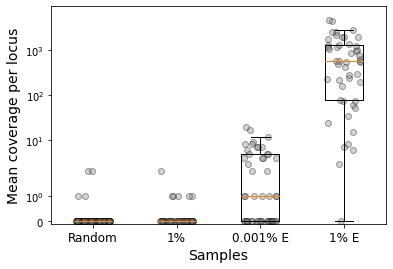

Mean Cov of mycobacterium loci increased from 0.14x to 944.45x in the 1% samples


In [11]:
#mycobacterium

a = list(mt_rand_df["c1p_control_enrich"])
b = list(mt_samp_df["c1p_control_no_enrich"])
c = list(mt_samp_df["c1e_3p_control_enrich"])
d = list(mt_samp_df["c1p_control_enrich"])

a_jitter=np.random.uniform(low=-0.2, high=0.2, size=(len(a),))
b_jitter=np.random.uniform(low= 0.8, high=1.2, size=(len(b),))
c_jitter=np.random.uniform(low= 1.8, high=2.2, size=(len(b),))
d_jitter=np.random.uniform(low= 2.8, high=3.2, size=(len(b),))


a_mean=np.median(a)
b_mean=np.median(b)
c_mean=np.median(c)
d_mean=np.median(d)

#plt.boxplot([a, b, c, d])
plt.scatter(x=a_jitter, y=a, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=b_jitter, y=b, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=c_jitter, y=c, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=d_jitter, y=d, alpha=0.35, color="grey", edgecolors="black")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Random", "1%", "0.001% E", "1% E"], size=12, rotation=0)
plt.ylabel("Mean coverage per locus", size=14)
plt.xlabel("Samples", size=14)
plt.yscale('symlog')
plt.ylim([-0.1,max(d)*2])

#plot means
# plt.plot([-0.2, 0.2], [a_mean, a_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 0.8, 1.2], [b_mean, b_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 1.8, 2.2], [c_mean, c_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 2.8, 3.2], [d_mean, d_mean], color='red', linestyle="dotted", linewidth=4)

box_plot_data=[a,b,c,d]
plt.boxplot(box_plot_data, positions=[0,1,2,3], showfliers=False)
plt.xticks(ticks=[0, 1, 2, 3], labels=["Random", "1%", "0.001% E", "1% E"], size=12, rotation=0)

#plt.savefig('mycobacterium_coverages.svg', facecolor="white")
plt.show()

plt.close()

print("Mean Cov of mycobacterium loci increased from {:.2f}x to {:.2f}x in the 1% samples".format(np.mean(b), np.mean(d)))

In [12]:
bs=[]
ds=[]
bs.extend(b)
ds.extend(d)

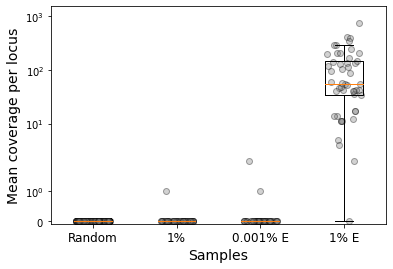

Mean Cov of Schistosoma loci increased from 0.02x to 117.92x in the 1% samples


In [13]:
#mycobacterium

a = list(sm_rand_df["c1p_control_enrich"])
b = list(sm_samp_df["c1p_control_no_enrich"])
c = list(sm_samp_df["c1e_3p_control_enrich"])
d = list(sm_samp_df["c1p_control_enrich"])

a_jitter=np.random.uniform(low=-0.2, high=0.2, size=(len(a),))
b_jitter=np.random.uniform(low= 0.8, high=1.2, size=(len(b),))
c_jitter=np.random.uniform(low= 1.8, high=2.2, size=(len(b),))
d_jitter=np.random.uniform(low= 2.8, high=3.2, size=(len(b),))

a_mean=np.median(a)
b_mean=np.median(b)
c_mean=np.median(c)
d_mean=np.median(d)

#plt.boxplot([a, b, c, d])
plt.scatter(x=a_jitter, y=a, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=b_jitter, y=b, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=c_jitter, y=c, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=d_jitter, y=d, alpha=0.35, color="grey", edgecolors="black")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Random", "1%", "0.001% E", "1% E"], size=12, rotation=0)
plt.ylabel("Mean coverage per locus", size=14)
plt.xlabel("Samples", size=14)
plt.yscale('symlog')
plt.ylim([-0.1,max(d)*2])

#plot means
# plt.plot([-0.2, 0.2], [a_mean, a_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 0.8, 1.2], [b_mean, b_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 1.8, 2.2], [c_mean, c_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 2.8, 3.2], [d_mean, d_mean], color='red', linestyle="dotted", linewidth=4)

box_plot_data=[a,b,c,d]
plt.boxplot(box_plot_data, positions=[0,1,2,3], showfliers=False)
plt.xticks(ticks=[0, 1, 2, 3], labels=["Random", "1%", "0.001% E", "1% E"], size=12, rotation=0)


plt.savefig('schistosoma_coverages.svg', facecolor="white")
plt.show()

plt.close()

print("Mean Cov of Schistosoma loci increased from {:.2f}x to {:.2f}x in the 1% samples".format(np.mean(b), np.mean(d)))

In [14]:
bs.extend(b)
ds.extend(d)

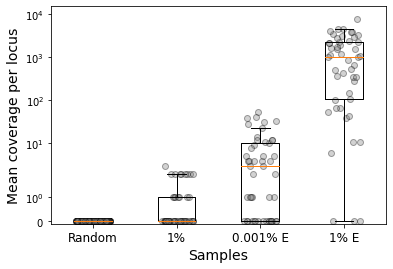

Mean Cov of Plasmodium loci increased from 0.53x to 1527.39x in the 1% samples


In [15]:
#mycobacterium

a = list(pf_rand_df["c1p_control_enrich"])
b = list(pf_samp_df["c1p_control_no_enrich"])
c = list(pf_samp_df["c1e_3p_control_enrich"])
d = list(pf_samp_df["c1p_control_enrich"])

a_jitter=np.random.uniform(low=-0.2, high=0.2, size=(len(a),))
b_jitter=np.random.uniform(low= 0.8, high=1.2, size=(len(b),))
c_jitter=np.random.uniform(low= 1.8, high=2.2, size=(len(b),))
d_jitter=np.random.uniform(low= 2.8, high=3.2, size=(len(b),))


a_mean=np.median(a)
b_mean=np.median(b)
c_mean=np.median(c)
d_mean=np.median(d)

#plt.boxplot([a, b, c, d])
plt.scatter(x=a_jitter, y=a, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=b_jitter, y=b, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=c_jitter, y=c, alpha=0.35, color="grey", edgecolors="black")
plt.scatter(x=d_jitter, y=d, alpha=0.35, color="grey", edgecolors="black")
plt.xticks(ticks=[0, 1, 2, 3], labels=["Random", "1%", "0.001% E", "1% E"], size=12, rotation=0)
plt.ylabel("Mean coverage per locus", size=14)
plt.xlabel("Samples", size=14)
plt.yscale('symlog')
plt.ylim([-0.1,max(d)*2])

#plot means
# plt.plot([-0.2, 0.2], [a_mean, a_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 0.8, 1.2], [b_mean, b_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 1.8, 2.2], [c_mean, c_mean], color='red', linestyle="dotted", linewidth=4)
# plt.plot([ 2.8, 3.2], [d_mean, d_mean], color='red', linestyle="dotted", linewidth=4)

box_plot_data=[a,b,c,d]
plt.boxplot(box_plot_data, positions=[0,1,2,3], showfliers=False)
plt.xticks(ticks=[0, 1, 2, 3], labels=["Random", "1%", "0.001% E", "1% E"], size=12, rotation=0)


plt.savefig('plasmodium_coverages.svg', facecolor="white")
plt.show()
plt.close()

print("Mean Cov of Plasmodium loci increased from {:.2f}x to {:.2f}x in the 1% samples".format(np.mean(b), np.mean(d)))

In [16]:
bs.extend(b)
ds.extend(d)

In [24]:
np.mean(ds)

0.23129251700680273

In [25]:
np.mean(ds)

863.2517006802722

In [27]:
np.mean(ds)/np.mean(bs)

3732.294117647059

In [144]:
genome_length=4_411_532
loc_start=2_374_354
loc_stop=2_374_989
probe_start=2_374_648
probe_stop=2_374_781

median probe cov = 8.0


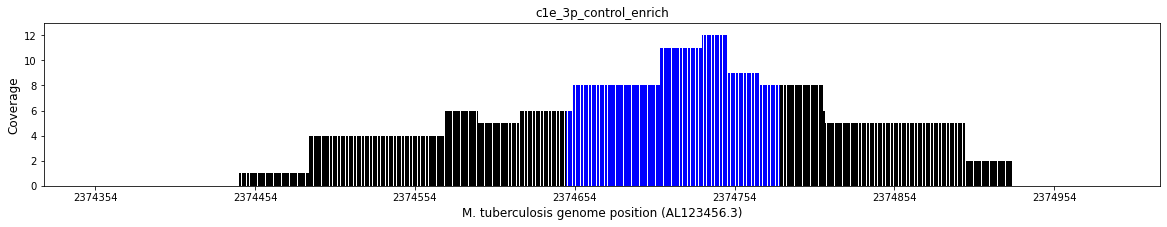

median probe cov = 1278.0


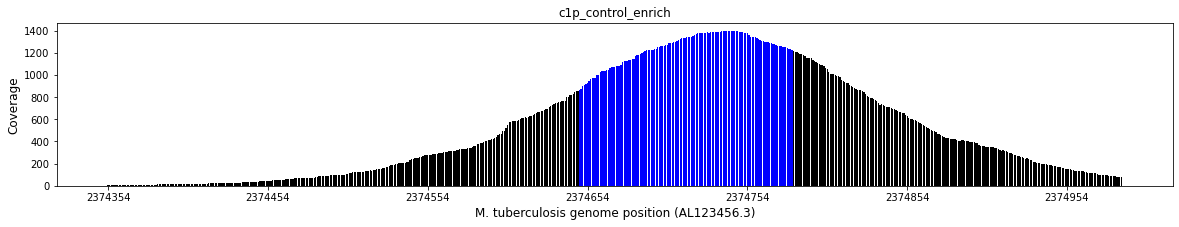

median probe cov = 1.0


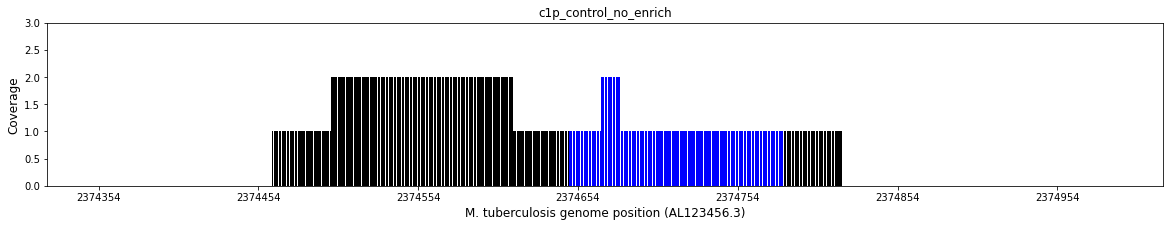

In [174]:
ref="mt"
samples = [ "c1e_3p_control_enrich", "c1p_control_enrich", "c1p_control_no_enrich"]

for sample in samples:
    sam_ref="{}_VS_{}".format(sample, ref)
    covs=[0]*(genome_length+1)

    with gzip.open('{}.per-base.bed.gz'.format(sam_ref),'rt') as modepth_file:        

        for base_line in modepth_file: 
            #print(base_line)
            chrom, cov_start, cov_end, cov = base_line.rstrip().split("\t")
            for site in range(int(cov_start), int(cov_end)+1):
                covs[site]=int(cov)

            #x_pos = np.arange(len(covs))
   
    #plot whole genome coverage
    fig = plt.gcf() 
    fig.set_size_inches(20, 3) 
    
   
    target_covs=covs[loc_start: loc_stop]
    x_pos=list(range(0, len(target_covs)))
    
    colors=len(x_pos)*["black"]

    probe_len=probe_stop - probe_start + 1
    probe_x_start=probe_start - loc_start + 1
    colors = colors[:probe_x_start] + ["blue"]*probe_len + colors[probe_x_start+probe_len:]

    plt.bar(x_pos, target_covs, color=colors)
    plt.xticks(ticks=x_pos[::100], labels=np.add(x_pos, loc_start)[::100])
    #plt.xlim(loc_start, loc_stop)
    
    y_max=int((np.max(target_covs)+1)*1.05)
    plt.ylim(0, y_max)

        
    plt.ylabel("Coverage".format(sample), size=12)
    plt.xlabel("M. tuberculosis genome position (AL123456.3)", size=12)
    plt.title("{}".format(sample))

    plt.savefig("{}_locus_coverage.svg".format(sample))
    plt.savefig("{}_locus_coverage.png".format(sample))

    print("median probe cov = {}".format(np.median(covs[probe_start:probe_stop])))
    plt.show()
    plt.close()